In [1]:
from pathlib import Path
from src.blocks import BlockAnalyzer, Block, block_decomposition, Decomposer

In [2]:
path_blocks = Path("out/blocks/Cluster_10644.json")
list_blocks = BlockAnalyzer()._load_list_blocks(path_blocks)

In [3]:
list_blocks

[Block(K=(1, 2), i=0, j=75, label='CACGATTCTCCCTTTGAGTTGATGAGGTTTCAGGGAAAAGGATAGCTGATTCTCCGCTTTTGCAAGTATGAAAGGC'),
 Block(K=(0, 1, 2), i=0, j=15, label='CACGATTCTCCCTTTG'),
 Block(K=(0, 1), i=17, j=81, label='GTTGATGAGGTTTCAGGGAAAAGGATAGCTGATTCTCCGCTTTTGCAAGTATGAAAGGCGAAAAA'),
 Block(K=(0, 1, 2), i=17, j=75, label='GTTGATGAGGTTTCAGGGAAAAGGATAGCTGATTCTCCGCTTTTGCAAGTATGAAAGGC'),
 Block(K=(0, 1, 2), i=77, j=81, label='AAAAA')]

In [4]:
decomposer=Decomposer()
new_blocks = decomposer(list_blocks)

In [5]:
len(new_blocks), len(list_blocks)

(9, 5)

In [7]:
from collections import defaultdict
d = defaultdict(int)
for block in new_blocks:
    d[ block ] +=1
d

defaultdict(int,
            {Block(K=(1, 2), i=16, j=75, label='AGTTGATGAGGTTTCAGGGAAAAGGATAGCTGATTCTCCGCTTTTGCAAGTATGAAAGGC'): 1,
             Block(K=(0, 1, 2), i=77, j=81, label='AAAAA'): 1,
             Block(K=(0, 1, 2), i=0, j=15, label='CACGATTCTCCCTTTG'): 1,
             Block(K=(0, 1), i=17, j=81, label='GTTGATGAGGTTTCAGGGAAAAGGATAGCTGATTCTCCGCTTTTGCAAGTATGAAAGGCGAAAAA'): 1,
             Block(K=(0, 1), i=17, j=76, label='GTTGATGAGGTTTCAGGGAAAAGGATAGCTGATTCTCCGCTTTTGCAAGTATGAAAGGCG'): 1,
             Block(K=(1, 2), i=0, j=75, label='CACGATTCTCCCTTTGAGTTGATGAGGTTTCAGGGAAAAGGATAGCTGATTCTCCGCTTTTGCAAGTATGAAAGGC'): 1,
             Block(K=(0, 1, 2), i=17, j=75, label='GTTGATGAGGTTTCAGGGAAAAGGATAGCTGATTCTCCGCTTTTGCAAGTATGAAAGGC'): 1,
             Block(K=(0, 1), i=76, j=81, label='GAAAAA'): 1,
             Block(K=(1, 2), i=0, j=16, label='CACGATTCTCCCTTTGA'): 1})

___
## Number of vertical identical cols in an MSA
Given an MSA, count the proportion (or number) of columns that contains only one character (or an indel) 

In [4]:
from Bio import AlignIO #load MSA
from src.utils.monitor_values_plus import MonitorValuesPlus

In [22]:
class AnalyzerMSA:

    def __init__(self, path_msa: str):
        self.path_msa = path_msa
        self.cols_msa = None # will be updated when the MSA is loaded
        self.seqs = self.get_seqs(path_msa)# sequences in the MSA

    def get_column(self, idx: int) -> list:
        return [seq[idx] for seq in self.seqs]

    def get_seqs(self,path_msa):
        # load MSA
        align=AlignIO.read(path_msa, "fasta")
        self.cols_msa = align.get_alignment_length()
        
        # extract sequences
        seqs = []
        for record in align:
            seqs.append(record.seq)
        return seqs

    def is_one_character(self, column) -> bool:
        chars = list(set(column)-set("-"))
        if len(chars)==1:
            return True
        return False

    def analyze_msa(self,) -> list[bool]:
        """evaluate each column and verify if it contains only one character 
        (indels are not taken into consideration)"""
        results = []
        for idx in range(self.cols_msa):
            column = self.get_column(idx)
            results.append(
                self.is_one_character(column)
            )
        return results

In [38]:
import pandas as pd
from pathlib import Path
# from rich.progress import track
from tqdm import tqdm
from src.utils import MonitorValuesPlus

mv = MonitorValuesPlus(list_vars=["path_msa","n_identical_cols","n_cols", "proportion"],
                        out_file="out/analysis-msa/stats.tsv",
                        overwrite=True)

# data_blocks=pd.read_csv("out/stats_blocks.tsv",sep="\t")
# list_paths = data_blocks["path_msa"].tolist()
list_paths = list(Path("/data/msas/msas").rglob("*.fa"))

for path_msa in tqdm(list_paths):
    try:
        amsa = AnalyzerMSA(path_msa)
        bool_cols = amsa.analyze_msa()

        # columns 
        n_identical_cols = sum(bool_cols)

        # length 
        n_cols = amsa.cols_msa

        # proportion between 
        proportion = round(100*n_identical_cols/n_cols, 2)

        mv()
    except: 
        continue

100%|██████████| 37425/37425 [08:50<00:00, 70.53it/s] 


In [40]:
stats_msa = pd.DataFrame(mv.values)
stats_msa.describe()

,n_identical_cols,n_cols,proportion
count,37421.000000,37421.000000,37421.000000
mean,520.609016,550.422811,95.767181
std,596.573503,635.783659,6.938184
min,25.000000,30.000000,30.770000
25%,169.000000,177.000000,93.230000
50%,312.000000,327.000000,99.800000
75%,692.000000,738.000000,100.000000
max,13377.000000,13377.000000,100.000000


<AxesSubplot: xlabel='proportion', ylabel='Count'>

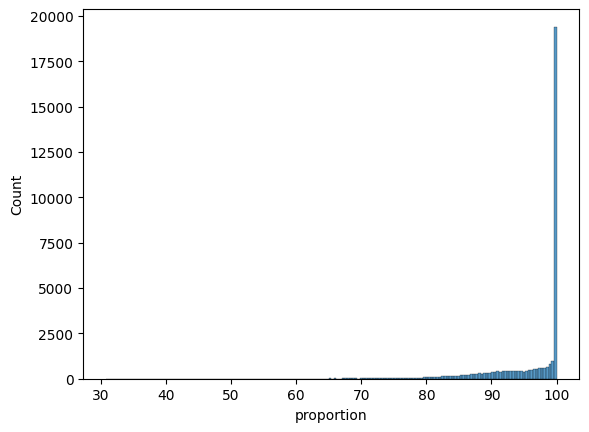

In [41]:
import seaborn as sns
sns.histplot(
    data=stats_msa,
    x="proportion"
)